# Making all trains and test similar and compatible

Rework of [this](2022-03-19_train-test_comparison.ipynb) notebook

## imports and reading data

In [1]:
from warnings import filterwarnings
from datetime import datetime

import re
import json

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from lib.data_viz_functions import *

filterwarnings("ignore")
sns.set()

## reading raw data

In [2]:
train_jane = pd.read_pickle("data/train_df_full_part1.pkl.zip", compression="zip")
train_baseline = pd.read_pickle("data/all_auto_ru_09_09_2020.pkl.zip", compression="zip")
test = pd.read_pickle("data/test.pkl.zip", compression="zip")

## viewing NAs

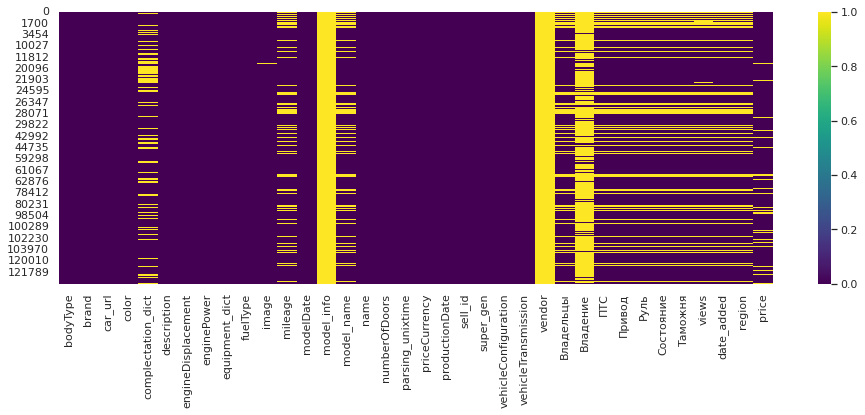

In [3]:
plt.figure(figsize=(16, 5))
sns.heatmap(train_jane.drop_duplicates(subset=["car_url"]).isna(), cmap="viridis")
plt.show()

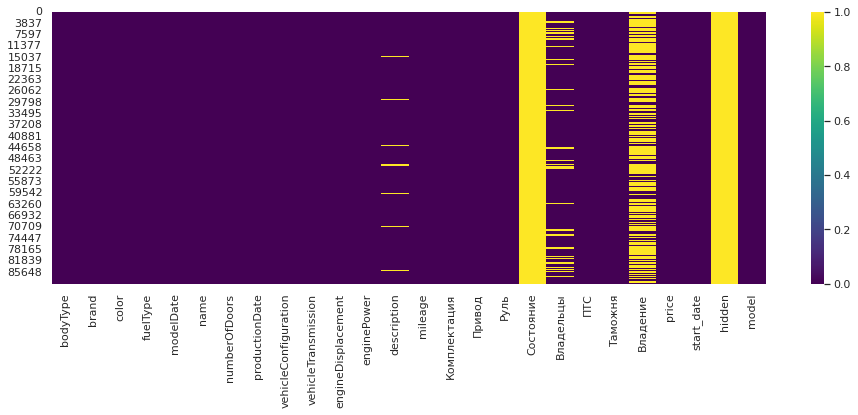

In [4]:
plt.figure(figsize=(16, 5))
sns.heatmap(train_baseline.drop_duplicates().isna(), cmap="viridis")
plt.show()

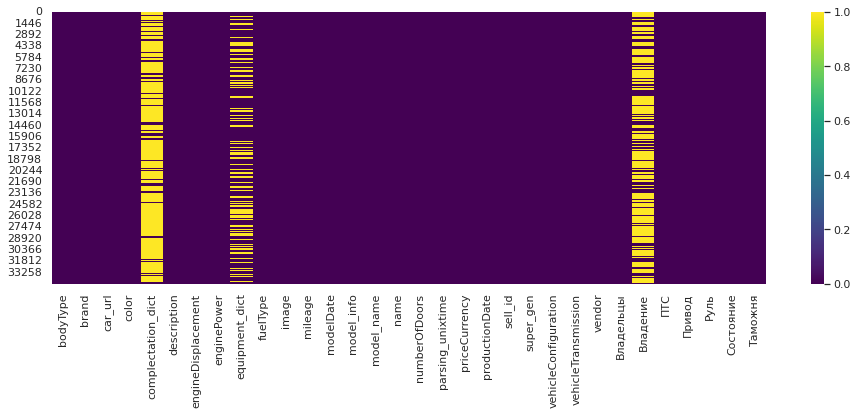

In [5]:
plt.figure(figsize=(16, 5))
sns.heatmap(test.drop_duplicates(subset=["car_url"]).isna(), cmap="viridis")
plt.show()

## functions and vocs for preprocessing

In [6]:
colors_dict = {
    "040001": "чёрный",
    "EE1D19": "красный",
    "0000CC": "синий",
    "CACECB": "серый",
    "007F00": "зелёный",
    "FAFBFB": "белый",
    "97948F": "серый",
    "22A0F8": "синий",
    "660099": "фиолетовый",
    "200204": "коричневый",
    "C49648": "коричневый",
    "DEA522": "золотистый",
    "4A2197": "фиолетовый",
    "FFD600": "жёлтый",
    "FF8649": "оранжевый",
    "FFC0CB": "розовый",
}

vendor_voc_additional = {
    "CADILLAC": "AMERICAN",
    "CHERY": "CHINESE",
    "CHEVROLET": "AMERICAN",
    "CHRYSLER": "AMERICAN",
    "CITROEN": "EUROPEAN",
    "DAEWOO": "KOREAN",
    "DODGE": "AMERICAN",
    "FORD": "AMERICAN",
    "GEELY": "CHINESE",
    "HYUNDAI": "KOREAN",
    "JAGUAR": "EUROPEAN",
    "JEEP": "AMERICAN",
    "KIA": "KOREAN",
    "MAZDA": "JAPANESE",
    "MINI": "EUROPEAN",
    "OPEL": "EUROPEAN",
    "PEUGEOT": "EUROPEAN",
    "PORSCHE": "EUROPEAN",
    "RENAULT": "EUROPEAN",
    "SUBARU": "JAPANESE",
    "SUZUKI": "JAPANESE",
    "GREAT_WALL": "CHINESE",
    "LAND_ROVER": "EUROPEAN",
    "SSANG_YONG": "KOREAN",
}

transmission_dict = {
    "роботизированная": "ROBOT",
    "автоматическая": "AUTOMATIC",
    "механическая": "MECHANICAL",
    "вариатор": "VARIATOR",
}


In [7]:
def parse_ownership_duration(train_str: str) -> int:
    """
    Processing "Владение" column
    Returns ownership duration in days (integer)
    """
    baseline_str = "{'year': 2020, 'month': 9}"
    if not isinstance(train_str, str):
        return np.nan
    elif "year" in str(train_str):
        baseline_dict = json.loads(baseline_str.replace("'", '"'))
        train_dict = json.loads(train_str.replace("'", '"'))
        baseline_date = datetime.strptime(
            f"{baseline_dict['year']}-{baseline_dict['month']}-1", "%Y-%m-%d"
        )
        train_date = datetime.strptime(
            f"{train_dict['year']}-{train_dict['month']}-1", "%Y-%m-%d"
        )
        return (baseline_date - train_date).days
    elif " и " in str(train_str):
        return (
            int(train_str.split(" ")[0]) * 365
            + int(train_str.split(" и ")[1].split(" ")[0]) * 30
        )
    else:
        return int(train_str.split(" ")[0]) * 365


def get_number_of_owners_from_owners(in_str):
    """
    Processing "Владельцы" column
    Extracting numbers from text
    """
    if not isinstance(in_str, str):
        return None
    else:
        result = in_str.replace("\xa0", "")
        return int(re.sub("\D", "", result))


def get_volume_from_vehicleConfiguration(in_str: str) -> str:
    """
    Processing "engineDisplacement"
    Extracting numbers but resurns as str: to convers using .astype method after
    """
    if not pd.isna(in_str):
        engine_volume = re.findall("[\d]*[.][\d]+", in_str)
        if len(engine_volume) >= 1:
            return engine_volume[0]
        else:
            return np.nan
    else:
        return np.nan


## cleanup start

### enginePower, engineDisplacement and name

In [8]:
train_jane["enginePower"] = train_jane["enginePower"].replace("undefined N12", None)
train_jane["enginePower"] = (
    train_jane[~pd.isna(train_jane["enginePower"])]["enginePower"]
    .str.split()
    .str.get(0)
    .astype("int")
)

In [9]:
test["enginePower"] = test["enginePower"].replace("undefined N12", None)
test["enginePower"] = (
    test[~pd.isna(test["enginePower"])]["enginePower"]
    .str.split()
    .str.get(0)
    .astype("int")
)

In [10]:
train_jane["engineDisplacement"] = train_jane["engineDisplacement"].replace(
    " LTR", None
)
train_jane["engineDisplacement"] = (
    train_jane[~pd.isna(train_jane["engineDisplacement"])]["engineDisplacement"]
    .str.split()
    .str.get(0)
    .astype("float")
)

In [11]:
train_baseline["engineDisplacement"] = (
    train_baseline["name"].apply(get_volume_from_vehicleConfiguration).astype("float64")
)

In [12]:
test["engineDisplacement"] = test["engineDisplacement"].replace(" LTR", None)
test["engineDisplacement"] = (
    test[~pd.isna(test["engineDisplacement"])]["engineDisplacement"]
    .str.split()
    .str.get(0)
    .astype("float")
)

### generating "used" col

In [13]:
train_jane["used"] = train_jane["car_url"].str.contains("used")

In [14]:
test["Владельцы"] = test["Владельцы"].apply(get_number_of_owners_from_owners)
train_jane["Владельцы"] = train_jane["Владельцы"].apply(
    get_number_of_owners_from_owners
)

In [15]:
train_jane["model_name"] = train_jane.model_name.apply(
    lambda x: x.lower() if not pd.isna(x) else x
)
test["model_name"] = test.model_name.apply(lambda x: x.lower() if not pd.isna(x) else x)

### vendor -- fillna

In [16]:
vendor_voc = (
    test[["brand", "vendor"]].drop_duplicates().set_index("brand").to_dict()["vendor"]
) | vendor_voc_additional

In [17]:
train_jane["vendor"] = train_jane["brand"].map(vendor_voc)
train_baseline["vendor"] = train_baseline["brand"].map(vendor_voc)

### dropna by vendor

In [18]:
train_jane.dropna(subset=["vendor"], axis="rows", inplace=True)

## deleting cols which can not be used by some reason. At least for now

In [19]:
del test["car_url"]
del test["complectation_dict"]
del test["equipment_dict"]
del test["image"]
del test["model_info"]
del test["name"]
del test["parsing_unixtime"]
del test["priceCurrency"]
del test["sell_id"]
del test["vehicleConfiguration"]
del test["Состояние"]
del test["Таможня"]
del test["super_gen"]
del test["model_name"]
del train_baseline["hidden"]
del train_baseline["name"]
del train_baseline["start_date"]
del train_baseline["vehicleConfiguration"]
del train_baseline["Комплектация"]
del train_baseline["Состояние"]
del train_baseline["Таможня"]
del train_baseline["model"]
del train_jane["car_url"]
del train_jane["complectation_dict"]
del train_jane["date_added"]
del train_jane["equipment_dict"]
del train_jane["image"]
del train_jane["model_info"]
del train_jane["name"]
del train_jane["parsing_unixtime"]
del train_jane["priceCurrency"]
del train_jane["region"]
del train_jane["sell_id"]
del train_jane["vehicleConfiguration"]
del train_jane["views"]
del train_jane["Состояние"]
del train_jane["Таможня"]
del train_jane["super_gen"]
del train_jane["used"]
del train_jane["model_name"]

## appending trains and further cleanup

In [20]:
train_jane["sample"] = "jane"
train_baseline["sample"] = "baseline"
train = pd.concat([train_jane, train_baseline])

In [21]:
train.drop_duplicates(inplace=True)
train.dropna(subset=["price"], inplace=True)
train.reset_index(drop=True, inplace=True)

In [22]:
train.loc[train.bodyType.isna()]

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,numberOfDoors,productionDate,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,price,sample
9723,NaN,HONDA,пурпурный,В хорошем состоянии на ходу,NaN,NaN,NaN,220000.0,NaN,NaN,1989.0,NaN,JAPANESE,3.0,NaN,Оригинал,NaN,Левый,110000.0,jane
59745,NaN,HONDA,CACECB,"Продаю Honda Civic Suttle 1989 г. выпуска, неу...",NaN,NaN,универсал,400000.0,NaN,NaN,1989.0,NaN,JAPANESE,3.0,NaN,ORIGINAL,NaN,LEFT,120000.0,baseline


In [23]:
train.dropna(subset="bodyType", inplace=True)

### Владение

In [24]:
train["Владение"] = train["Владение"].apply(parse_ownership_duration)
test["Владение"] = test["Владение"].apply(parse_ownership_duration)

### bodyType

In [25]:
train["bodyType"] = train["bodyType"].str.replace("-", " ")
train["bodyType"] = train["bodyType"].str.lower()

In [26]:
train["bodyType"] = train["bodyType"].str.replace("-", " ")
test["bodyType"] = test["bodyType"].str.replace("-", " ")

In [27]:
train["bodyType"] = train["bodyType"].apply(
    lambda x: x.split()[0] if not pd.isna(x) else x
)
test["bodyType"] = test["bodyType"].apply(
    lambda x: x.split()[0] if not pd.isna(x) else x
)

### color

In [28]:
train["color"].replace(colors_dict, inplace=True)

### vehicleTransmission

In [29]:
test["vehicleTransmission"] = test["vehicleTransmission"].replace(transmission_dict)
train["vehicleTransmission"] = train["vehicleTransmission"].replace(transmission_dict)

### ПТС and Руль

In [30]:
train["ПТС"].replace({"ORIGINAL": "Оригинал", "DUPLICATE": "Дубликат"}, inplace=True)
train["Руль"].replace({"LEFT": "Левый", "RIGHT": "Правый"}, inplace=True)

### description

In [31]:
train["description"] = train["description"].str.lower()
test["description"] = test["description"].str.lower()

In [32]:
r = re.compile("[\W_]+")

In [33]:
train["description"] = train["description"].apply(
    lambda x: r.sub(" ", x) if not pd.isna(x) else x
)
test["description"] = test["description"].apply(
    lambda x: r.sub(" ", x) if not pd.isna(x) else x
)

### converting types

In [34]:
train.loc[train["bodyType"].isna() == False, "bodyType"] = train["bodyType"].astype("str")
train.loc[train["brand"].isna() == False, "brand"] = train["brand"].astype("str")
train.loc[train["color"].isna() == False, "color"] = train["color"].astype("str")
train.loc[train["description"].isna() == False, "description"] = train["description"].astype("str")
train.loc[train["engineDisplacement"].isna() == False, "engineDisplacement"] = train["engineDisplacement"].astype("float32")
train.loc[train["enginePower"].isna() == False, "enginePower"] = train["enginePower"].astype("float32")
train.loc[train["fuelType"].isna() == False, "fuelType"] = train["fuelType"].astype("str")
train.loc[train["mileage"].isna() == False, "mileage"] = train["mileage"].astype("float32")
train.loc[train["modelDate"].isna() == False, "modelDate"] = train["modelDate"].astype("float32")
train.loc[train["numberOfDoors"].isna() == False, "numberOfDoors"] = train["numberOfDoors"].astype("float32")
train.loc[train["productionDate"].isna() == False, "productionDate"] = train["productionDate"].astype("float32")
train.loc[train["vehicleTransmission"].isna() == False, "vehicleTransmission"] = train["vehicleTransmission"].astype("str")
train.loc[train["vendor"].isna() == False, "vendor"] = train["vendor"].astype("str")
train.loc[train["Владельцы"].isna() == False, "Владельцы"] = train["Владельцы"].astype("float32")
train.loc[train["Владение"].isna() == False, "Владение"] = train["Владение"].astype("float32")
train.loc[train["ПТС"].isna() == False, "ПТС"] = train["ПТС"].astype("str")
train.loc[train["Привод"].isna() == False, "Привод"] = train["Привод"].astype("str")
train.loc[train["Руль"].isna() == False, "Руль"] = train["Руль"].astype("str")

train.loc[train["price"].isna() == False, "price"] = train["price"].astype("float64")

test.loc[test["bodyType"].isna() == False, "bodyType"] = test["bodyType"].astype("str")
test.loc[test["brand"].isna() == False, "brand"] = test["brand"].astype("str")
test.loc[test["color"].isna() == False, "color"] = test["color"].astype("str")
test.loc[test["description"].isna() == False, "description"] = test["description"].astype("str")
test.loc[test["engineDisplacement"].isna() == False, "engineDisplacement"] = test["engineDisplacement"].astype("float32")
test.loc[test["enginePower"].isna() == False, "enginePower"] = test["enginePower"].astype("float32")
test.loc[test["fuelType"].isna() == False, "fuelType"] = test["fuelType"].astype("str")
test.loc[test["mileage"].isna() == False, "mileage"] = test["mileage"].astype("float32")
test.loc[test["modelDate"].isna() == False, "modelDate"] = test["modelDate"].astype("float32")
test.loc[test["numberOfDoors"].isna() == False, "numberOfDoors"] = test["numberOfDoors"].astype("float32")
test.loc[test["productionDate"].isna() == False, "productionDate"] = test["productionDate"].astype("float32")
test.loc[test["vehicleTransmission"].isna() == False, "vehicleTransmission"] = test["vehicleTransmission"].astype("str")
test.loc[test["vendor"].isna() == False, "vendor"] = test["vendor"].astype("str")
test.loc[test["Владельцы"].isna() == False, "Владельцы"] = test["Владельцы"].astype("float32")
test.loc[test["Владение"].isna() == False, "Владение"] = test["Владение"].astype("float32")
test.loc[test["ПТС"].isna() == False, "ПТС"] = test["ПТС"].astype("str")
test.loc[test["Привод"].isna() == False, "Привод"] = test["Привод"].astype("str")
test.loc[test["Руль"].isna() == False, "Руль"] = test["Руль"].astype("str")

In [35]:
train.columns.tolist()

['bodyType',
 'brand',
 'color',
 'description',
 'engineDisplacement',
 'enginePower',
 'fuelType',
 'mileage',
 'modelDate',
 'numberOfDoors',
 'productionDate',
 'vehicleTransmission',
 'vendor',
 'Владельцы',
 'Владение',
 'ПТС',
 'Привод',
 'Руль',
 'price',
 'sample']

## reviewing before write

In [36]:
train[train.columns.sort_values().tolist()].sample(5, random_state=42).T

,100912,7187,89066,103550,107137
bodyType,внедорожник,внедорожник,хэтчбек,хэтчбек,минивэн
brand,TOYOTA,HONDA,PEUGEOT,VOLKSWAGEN,VOLKSWAGEN
color,зелёный,чёрный,красный,зелёный,серый
description,в хорошем состоянии номера все читаются салон ...,лот 01281758 skoda фаворит моторс юг особеннос...,состояние нового авто пробег родной 64500 в од...,легендарный и единственный в своем роде golf r...,продаю фольксваген шаран в моих руках с 2003 г...
engineDisplacement,4.0,2.0,1.6,2.0,2.8
enginePower,249.0,150.0,120.0,256.0,174.0
fuelType,бензин,бензин,бензин,бензин,бензин
mileage,320260.0,266394.0,64500.0,195311.0,360000.0
modelDate,2002.0,2009.0,2007.0,2009.0,1995.0
numberOfDoors,5.0,5.0,5.0,5.0,5.0


In [37]:
test[test.columns.sort_values().tolist()].sample(5, random_state=42).T

,19026,3337,11807,18661,11783
bodyType,внедорожник,седан,внедорожник,кабриолет,внедорожник
brand,TOYOTA,AUDI,NISSAN,MERCEDES,NISSAN
color,чёрный,синий,белый,серый,серебристый
description,лот 01215604 фаворит хофф вы можете получить с...,авто в идеальном состоянии проблем нет смотрит...,комфорт 6 безопасность 4 обзор 2 салон 2,покупал автомобиль весной у дилера мв измайлов...,система удаленного запуска двигателя
engineDisplacement,2.0,1.8,2.0,1.8,2.0
enginePower,150.0,125.0,141.0,184.0,141.0
fuelType,бензин,бензин,бензин,бензин,бензин
mileage,121490.0,240000.0,104842.0,68000.0,170000.0
modelDate,2000.0,1994.0,2010.0,2009.0,2010.0
numberOfDoors,5.0,4.0,5.0,2.0,5.0


### bodyType

In [38]:
train.bodyType.value_counts(dropna=False)

внедорожник    48273
седан          40795
хэтчбек        12625
лифтбек         6089
универсал       4502
минивэн         2990
компактвэн      2554
купе            2103
пикап            803
кабриолет        242
родстер          194
фургон           175
микровэн          54
тарга              9
лимузин            7
фастбек            3
Name: bodyType, dtype: int64

In [39]:
test.bodyType.value_counts(dropna=False)

седан          13165
внедорожник    12346
хэтчбек         2609
лифтбек         2232
универсал       1276
минивэн          995
купе             982
компактвэн       489
пикап            290
родстер           99
фургон            97
кабриолет         90
микровэн           7
лимузин            6
тарга              2
фастбек            1
Name: bodyType, dtype: int64

### brand

In [40]:
train.brand.value_counts(dropna=False)

MERCEDES      10793
BMW           10476
VOLKSWAGEN     9586
NISSAN         8503
TOYOTA         7481
AUDI           7185
SKODA          6266
MITSUBISHI     5797
HYUNDAI        5543
KIA            5486
VOLVO          5136
FORD           4763
HONDA          4486
LEXUS          4019
CHEVROLET      3588
OPEL           3092
RENAULT        2682
INFINITI       2425
MAZDA          2278
PEUGEOT        1603
LAND_ROVER     1565
CITROEN        1120
DAEWOO         1028
SUBARU          927
SUZUKI          842
SSANG_YONG      707
PORSCHE         699
CHERY           559
JEEP            456
GREAT_WALL      416
DODGE           412
CADILLAC        317
CHRYSLER        316
MINI            303
JAGUAR          294
GEELY           269
Name: brand, dtype: int64

In [41]:
test.brand.value_counts(dropna=False)

BMW           4473
VOLKSWAGEN    4404
NISSAN        4393
MERCEDES      4180
TOYOTA        3913
AUDI          3421
MITSUBISHI    2843
SKODA         2741
VOLVO         1463
HONDA         1150
INFINITI       871
LEXUS          834
Name: brand, dtype: int64

### color

In [42]:
train.color.value_counts(dropna=False)

чёрный         34299
серый          26211
белый          23262
синий          13041
коричневый      6889
красный         6060
зелёный         3273
серебристый     3232
фиолетовый      1517
золотистый       944
жёлтый           812
бежевый          687
оранжевый        625
голубой          355
пурпурный        173
розовый           38
Name: color, dtype: int64

In [43]:
test.color.value_counts(dropna=False)

чёрный         11010
белый           6133
серебристый     4113
серый           3984
синий           3289
красный         1531
коричневый      1501
зелёный          952
бежевый          639
голубой          457
золотистый       266
пурпурный        254
фиолетовый       219
жёлтый           194
оранжевый        131
розовый           13
Name: color, dtype: int64

### description

In [44]:
train.description[42]

'при покупке данного автомобиля в кредит вы получите дополнительную скидку до 100 000 рублей а также воспользовавшись нашей программой trade in получите помимо выгодной цены за ваш старый автомобиль скидку до 50 000 рублей скидки суммируются поэтому вы можете получить выгоду до 150 000 рублей воспользовавшись обеими предложениями все автомобили представленные в продаже проходят диагностику так же была осуществлена полная предпродажная подготовка и полировка кузова предоставляем гарантию юридической чистоты а так же год технической гарантии на двигатель и кпп в письменной форме каждому нашему клиенту мы дарим на выбор комплект новой резины полное комплексное то страховой полис осаго сроком на 3 месяца действует программа льготного автокредитования со ставкой по кредиту от 4 9 помимо покупки за наличные или обмена по trade in вы можете воспользоваться одной из нескольких выгодных программ автокредитования от наших банков партнеров минимальный пакет документов быстрое решение низкая проце

### engineDisplacement

In [45]:
train.engineDisplacement.value_counts(dropna=False)

2.0    30066
1.6    22866
3.0    10005
1.8     7778
1.4     7700
       ...  
6.5        1
8.1        1
8.2        1
8.4        1
7.3        1
Name: engineDisplacement, Length: 69, dtype: int64

In [46]:
test.engineDisplacement.value_counts(dropna=False)

2.0    7391
1.6    4973
3.0    3915
1.8    3349
2.5    2477
2.4    1745
3.5    1710
1.4    1635
1.5     725
1.2     485
4.4     447
2.8     384
4.7     377
1.3     365
5.5     361
4.0     356
3.2     348
4.5     346
2.1     271
3.7     242
2.2     236
4.2     228
1.9     221
2.3     203
2.7     189
3.6     183
5.6     170
5.0     158
5.7     135
2.9     131
4.6     108
3.1      88
4.8      84
1.7      59
1.0      57
3.8      57
2.6      55
NaN      55
6.0      53
0.7      53
3.3      44
3.4      36
4.1      35
4.3      32
5.4      31
6.2      28
5.2      12
5.9      12
6.3       8
5.8       7
6.6       6
4.9       4
1.1       4
3.9       1
5.3       1
Name: engineDisplacement, dtype: int64

### enginePower

In [47]:
train.enginePower.value_counts(dropna=False)

150.0    9520
249.0    6865
140.0    3697
110.0    3587
190.0    3216
         ... 
251.0       1
492.0       1
702.0       1
526.0       1
466.0       1
Name: enginePower, Length: 408, dtype: int64

In [48]:
test.enginePower.value_counts(dropna=False)

249.0    1708
150.0    1699
110.0    1039
170.0     977
105.0     955
         ... 
514.0       1
626.0       1
38.0        1
32.0        1
301.0       1
Name: enginePower, Length: 315, dtype: int64

### fuelType

In [49]:
train.fuelType.value_counts(dropna=False)

бензин     101135
дизель      19170
гибрид        920
электро       181
газ            12
Name: fuelType, dtype: int64

In [50]:
test.fuelType.value_counts(dropna=False)

бензин     28601
дизель      5800
гибрид       223
электро       55
газ            7
Name: fuelType, dtype: int64

### mileage

In [51]:
train.mileage.value_counts(dropna=False)

0.0         10535
NaN          5777
200000.0     1410
150000.0     1244
180000.0     1091
            ...  
80760.0         1
150039.0        1
36164.0         1
40089.0         1
191768.0        1
Name: mileage, Length: 28799, dtype: int64

In [52]:
test.mileage.value_counts(dropna=False)

200000.0    436
150000.0    382
300000.0    381
180000.0    347
250000.0    346
           ... 
140237.0      1
121449.0      1
210311.0      1
121363.0      1
157965.0      1
Name: mileage, Length: 11268, dtype: int64

### modelDate

In [53]:
train.modelDate.value_counts(dropna=False)

2017.0    8221
2010.0    7803
2006.0    7536
2009.0    6914
2012.0    6462
          ... 
1969.0       1
1934.0       1
1950.0       1
1953.0       1
1904.0       1
Name: modelDate, Length: 80, dtype: int64

In [54]:
test.modelDate.value_counts(dropna=False)

2010.0    2503
2013.0    2275
2008.0    2243
2011.0    2173
2006.0    2169
          ... 
1973.0       1
1965.0       1
1969.0       1
1934.0       1
1960.0       1
Name: modelDate, Length: 66, dtype: int64

### numberOfDoors

In [55]:
train.numberOfDoors.value_counts(dropna=False)

5.0    73367
4.0    42897
2.0     2628
3.0     2525
0.0        1
Name: numberOfDoors, dtype: int64

In [56]:
test.numberOfDoors.value_counts(dropna=False)

5.0    18703
4.0    14126
2.0     1206
3.0      650
0.0        1
Name: numberOfDoors, dtype: int64

### productionDate

In [57]:
train.productionDate.value_counts(dropna=False)

2020.0    11144
2012.0     8777
2008.0     8639
2011.0     7999
2013.0     7642
          ...  
1931.0        1
1971.0        1
1955.0        1
1948.0        1
1936.0        1
Name: productionDate, Length: 81, dtype: int64

In [58]:
test.productionDate.value_counts(dropna=False)

2012.0    2798
2008.0    2606
2011.0    2589
2013.0    2488
2014.0    2134
          ... 
1904.0       1
1936.0       1
1968.0       1
1939.0       1
1948.0       1
Name: productionDate, Length: 69, dtype: int64

### vehicleTransmission

In [59]:
train.vehicleTransmission.value_counts(dropna=False)

AUTOMATIC     67906
MECHANICAL    30233
ROBOT         11910
VARIATOR      11369
Name: vehicleTransmission, dtype: int64

In [60]:
test.vehicleTransmission.value_counts(dropna=False)

AUTOMATIC     19596
MECHANICAL     7209
VARIATOR       3999
ROBOT          3882
Name: vehicleTransmission, dtype: int64

### vendor

In [61]:
train.vendor.value_counts(dropna=False)

EUROPEAN    60800
JAPANESE    36758
KOREAN      12764
AMERICAN     9852
CHINESE      1244
Name: vendor, dtype: int64

In [62]:
test.vendor.value_counts(dropna=False)

EUROPEAN    20682
JAPANESE    14004
Name: vendor, dtype: int64

### Владельцы

In [63]:
train.Владельцы.value_counts(dropna=False)

3.0    48553
1.0    28413
2.0    28140
NaN    16312
Name: Владельцы, dtype: int64

In [64]:
test.Владельцы.value_counts(dropna=False)

3.0    15957
1.0     9459
2.0     9270
Name: Владельцы, dtype: int64

### Владение

In [65]:
train.Владение.value_counts(dropna=False)

NaN       86489
701.0       492
397.0       491
762.0       486
731.0       470
          ...  
6295.0        1
6690.0        1
5380.0        1
9790.0        1
8463.0        1
Name: Владение, Length: 537, dtype: int64

In [66]:
test.Владение.value_counts(dropna=False)

NaN        22691
730.0        267
365.0        259
1460.0       231
1095.0       228
           ...  
9580.0         1
15630.0        1
8455.0         1
12470.0        1
8300.0         1
Name: Владение, Length: 265, dtype: int64

### ПТС

In [67]:
train.ПТС.value_counts(dropna=False)

Оригинал    100888
Дубликат     14405
NaN           6125
Name: ПТС, dtype: int64

In [68]:
test.ПТС.value_counts(dropna=False)

Оригинал    30098
Дубликат     4587
NaN             1
Name: ПТС, dtype: int64

### Привод

In [69]:
train.Привод.value_counts(dropna=False)

передний    58354
полный      48261
задний       9026
NaN          5777
Name: Привод, dtype: int64

In [70]:
test.Привод.value_counts(dropna=False)

передний    15565
полный      15020
задний       4101
Name: Привод, dtype: int64

### Руль

In [71]:
train.Руль.value_counts(dropna=False)

Левый     111645
NaN         5778
Правый      3995
Name: Руль, dtype: int64

In [72]:
test.Руль.value_counts(dropna=False)

Левый     33287
Правый     1399
Name: Руль, dtype: int64

### price

Unique values count: 12511 
Q1: 400000.0
Q3: 1760000.0
IQR: 1360000.0 
Outliers borders: [-1640000.0, 3800000.0]


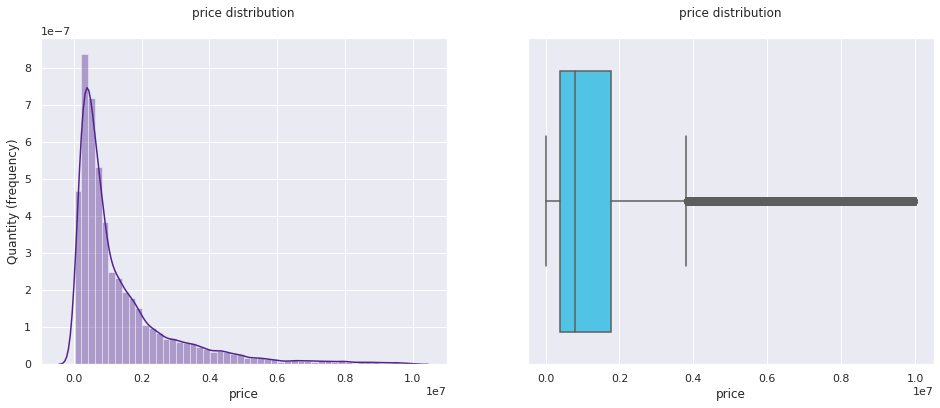

In [73]:
show_IQR(train.query("price < 10_000_000").price)

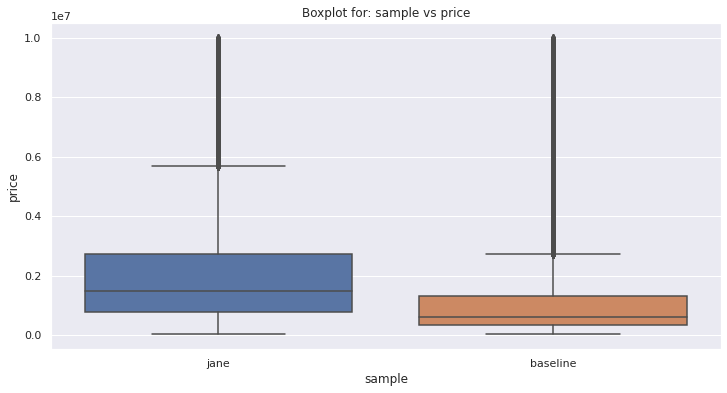

In [74]:
show_boxplots(train.query("price < 10_000_000"), "sample", "price")

## writing results to files

In [75]:
train.to_pickle("data/2022-03-30_train_preprocessed.pkl.zip", compression="zip")
test.to_pickle("data/2022-03-30_test_preprocessed.pkl.zip", compression="zip")

Next: [EDA](2022-03-31_train-test_EDA.ipynb)